In [21]:
import torch 
import spacy
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

In [28]:
#TAKEN FROM PYTORCH WEBSITE 

multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

# Place-holders
token_transform = {}
vocab_transform = {}

#The tokenizer just breaks sentences up into tokens i.e. words, punctuation etc. 
token_transform[SRC_LANGUAGE] = get_tokenizer("spacy", language="en_core_web_sm")
token_transform[TGT_LANGUAGE] = get_tokenizer("spacy", language="de_core_news_sm")

# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)


It might be worth also testing en_core_web_md the md meaning "medium" instead of small which uitilises word vectors unlike the current download. 
this can be done using 
python3.11 -m spacy download en_core_web_md
python3.11 -m spacy download de_core_news_md

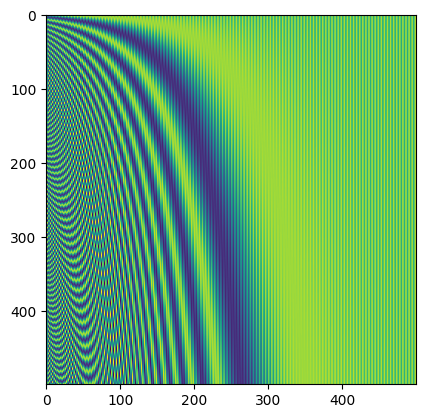

In [6]:
#COMPLETED ENTIRELY INDEPENDENTLY 

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
import matplotlib.pyplot as plt 
import numpy as np
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    "Compute Sinusoidal Positional Encoding"
    def __init__(self):
        super().__init__()
    
    def forward(self, dim):
        #POS is the position in the sentence 
        #d_model is the dimension in the encoded space 
        PE = torch.zeros(dim)
        d_model = dim[1]
        pos = dim[0]
        PE += torch.arange(pos).unsqueeze(1)
        i_vec_sin = torch.arange(0, d_model, 2)/d_model
        i_vec_cos = torch.arange(1, d_model, 2)/d_model
        PE[:, ::2] = torch.sin(torch.exp(torch.log(PE[:, ::2]) - i_vec_sin * np.log(10000)))
        PE[:, 1::2] = torch.cos(torch.exp(torch.log(PE[:, 1::2]) - i_vec_cos * np.log(10000)))
        return PE
    
A = PositionalEncoding()
b = A((500,500))
plt.imshow(b)        

In [7]:
#The input embedding is then the vectorised text sequence. 
#The embedding module creates and stores the word embeddings in a useful way that are accesible via indices
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    
    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)


In [8]:
#Single layer of attention 
class Attention(nn.Module):
    def __init__(self, d_model: int, d_k: int):
        """
        d_model -> Embedding space
        d_k -> d_model/h where h is the number of heads of the MultiHead Attention 
        """
        super(Attention, self).__init__()
        self.wq = nn.Linear(d_model, d_k, device=DEVICE)
        self.wk = nn.Linear(d_model, d_k, device=DEVICE)
        self.wv = nn.Linear(d_model, d_k, device=DEVICE)
        self.dmodel = d_model
        self.dk = d_k

    def forward(self, x, *args):
        """
        
        x -> input tensor (generally word sequence)

        """

        #In a self attention block x=y, in the encoder-decoder attention only the keys and values come from the encoder output
        if args:
            #Encoder-Decoder Attention
            y = args[0]
        else:
            #Self-Attention
            y = x

        q = y @ self.wq
        k = x @ self.wk
        v = x @ self.wv

        score = q @ k.transpose(2,3) / np.sqrt(self.dk)
        out = nn.Softmax(-1)(score) @ v
        return out, score

#Multi-Head Attention 
#h is the number of heads that we will use (same letter as used in the paper)

class MultiHead(nn.Module):
    def __init__(self, h: int, d_model: int):
        """
        h -> number of heads 
        d_model -> dimension of the model embedding
        """
        super(MultiHead, self).__init__()
        self.dk = int(d_model / h)
        self.dmodel = d_model 
        self.h = h
        self.weights = nn.ModuleList([Attention(self.dmodel, self.dk) for _ in range(self.h)])
        self.W = nn.Linear(self.dmodel, self.dmodel)

    def forward(self, x):
        outputs = []
        for attention_layer in self.weights:
            out, score = attention_layer(x)
            outputs.append(out)
        concat_output = outputs[0]
        for i in outputs[1:]:
            concat_output = torch.cat((concat_output, i), 0)
        return concat_output

In [9]:
#FeedForward Neural Network

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_hidden: int):
        super(FeedForward, self).__init__()
        self.layer1 = nn.Linear(d_model, d_hidden, device=DEVICE)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(d_hidden, d_model, device=DEVICE)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x 

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-6):
        """
        d_model -> Dimension of Model 
        eps -> Value to prevent Division by zero 
        """
        super(LayerNorm, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        """
        x -> Normalisation input 
        """

        mu = x.mean(dim=-1)
        std = x.std(dim=-1)

        x_norm = (x - mu)/(std + self.eps)
        output = x_norm * self.gamma + self.beta 
        return output 

In [13]:
class Encoder(nn.Module):
    def __init__(self, h: int, d_model: int, d_hidden):
        """
        h -> Number of Attention heads
        d_model -> Dimension of the embedding space 
        d_hidden -> Number of hidden layers in the feedforward network
        """
        super(Encoder, self).__init__()
        self.mha = MultiHead(h, d_model)
        self.ffn = FeedForward(d_model, d_hidden)
        self.layernorm1 = LayerNorm(d_model)
        self.layernorm2 = LayerNorm(d_model)
        
    def forward(self, x):
        """
        x -> Input 
        """

        x += self.mha(x)
        x = self.layernorm1(x)
        x += self.ffn(x)
        x = self.layernorm2(x)
        return x 

In [15]:
class Decoder(nn.Module):
    def __init__(self, h, d_model, d_hidden):
        super(Decoder, self).__init__()
        self.masked = MultiHead(h, d_model)
        #eda - encoder- decoder attention
        self.eda = MultiHead(h, d_model)
        self.ffn = FeedForward(d_model, d_hidden)
        self.layernorm1 = LayerNorm(d_model)
        self.layernorm2 = LayerNorm(d_model)
        self.layernorm3 = LayerNorm(d_model)
    
    def forward(self, x, y):
        """
        x -> Output from encoder 
        y -> target sequence 
        """
        y += self.masked(y)
        y = self.layernorm1(y)
        y += self.eda(x, y)
        y = self.layernorm2(y)
        y += self.ffn(y)
        y = self.layernorm3(y)

        return y 

In [17]:
def mask(y, i):
    """ 
    Return a masking of y from the i'th position onwards

    i -> index indicating position 
    """

    x = torch.zeros(y.size())
    x[:, :, :i] = y[:, :, :i]
    return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, h, N, d_model, d_hidden, d_output):
        """
        x -> Input sequence
        y -> Output sequence 
        h -> Number of heads 
        N -> Number of Encoder and Decoder layers 
        d_model -> Dimension of the model 
        d_hidden -> Number of hidden layers for the feed-forward model
        d_input -> Dimension of input (size of input language)
        d_output -> Dimension of output (size of output language)

        """
        super(Transformer, self).__init__()
        self.EncoderLayers = nn.ModuleList()
        self.DecoderLayers = nn.ModuleList()
        for _ in range(N):
            self.EncoderLayers.append(Encoder(h, d_model, d_hidden))
            self.DecoderLayers.append(Decoder(h, d_model, d_hidden))
        self.Linearlayer = nn.Linear(d_model, d_output)
        self.smax = nn.Softmax(d_output)
        self.pe = PositionalEncoding()
  
    def train(self, x, y):
        x += self.pe(x.size())
        y += self.pe(y.size())
        for encoder in self.EncoderLayers:
            x = encoder(x)

        for i in range(x.size(dim=-1)):
            y_mask = mask(y, i)
            for decoder in self.DecoderLayers:
                y_mask = decoder(self.x, y_mask)
        
            y_mask = self.Linearlayer(y_mask)

            #Probability vector for the i'th term 
            output = self.smax(y_mask)
            



        return 
    
    def forward(self, x):
        x += self.pe(x.size())
        #set Y to beginning of sentence token. 
        #y = 
        y += self.pe(y.size())
        for encoder in self.EncoderLayers:
            x = encoder(x)

        z = y
        for i in range(x.size(dim=-1)):
            for decoder in self.DecoderLayers:
                z = decoder(self.x, z)
        y = torch.cat((y, z), dim=-1)
        y = self.Linearlayer(y)
        return self.smax(y)

